# Analysis tutorial

The `analysis` module offers a number of scripts, including: 

- simple checks of slab thickness 
- atom displacement after relaxation 
- plotting the planar average of the electrostatic potenital through the slab and vacuum. 

The module relies heavily on the `pymatgen.analysis.local_env` module. Caution should be exercised when using the bond analysis and nearest neighbours functionalities with default settings.

In [1]:
# Import from relevant surfaxe modules
from surfaxe.analysis import cart_displacements, bond_analysis, \
electrostatic_potential, simple_nn, complex_nn, surface_dipole

# Create a path to the examples folder
from pathlib import Path 
path_to_analysis_data = Path.cwd().parents[1].joinpath('example_data/analysis')

## Bond analysis 
Consistent bond lengths in c-direction (perpendicular to the surface) in a fully relaxed slab are an indicator of a sufficient slab thickness, i.e. that you have a bulk-like region in the centre. 

The `bond_analysis` function takes the slab structure file and the atom pairs under consideration to asses the bonding distance using the `CrystalNN` algorithm. The validity of the nearest neighbour finding algorithm should be checked on the bulk structure as some struggle with more complex systems - `CrystalNN` and `MinimumDistanceNN` are a good start. 

As in other modules, oxidation states are added by guess by default, but can be added by element or site as well.

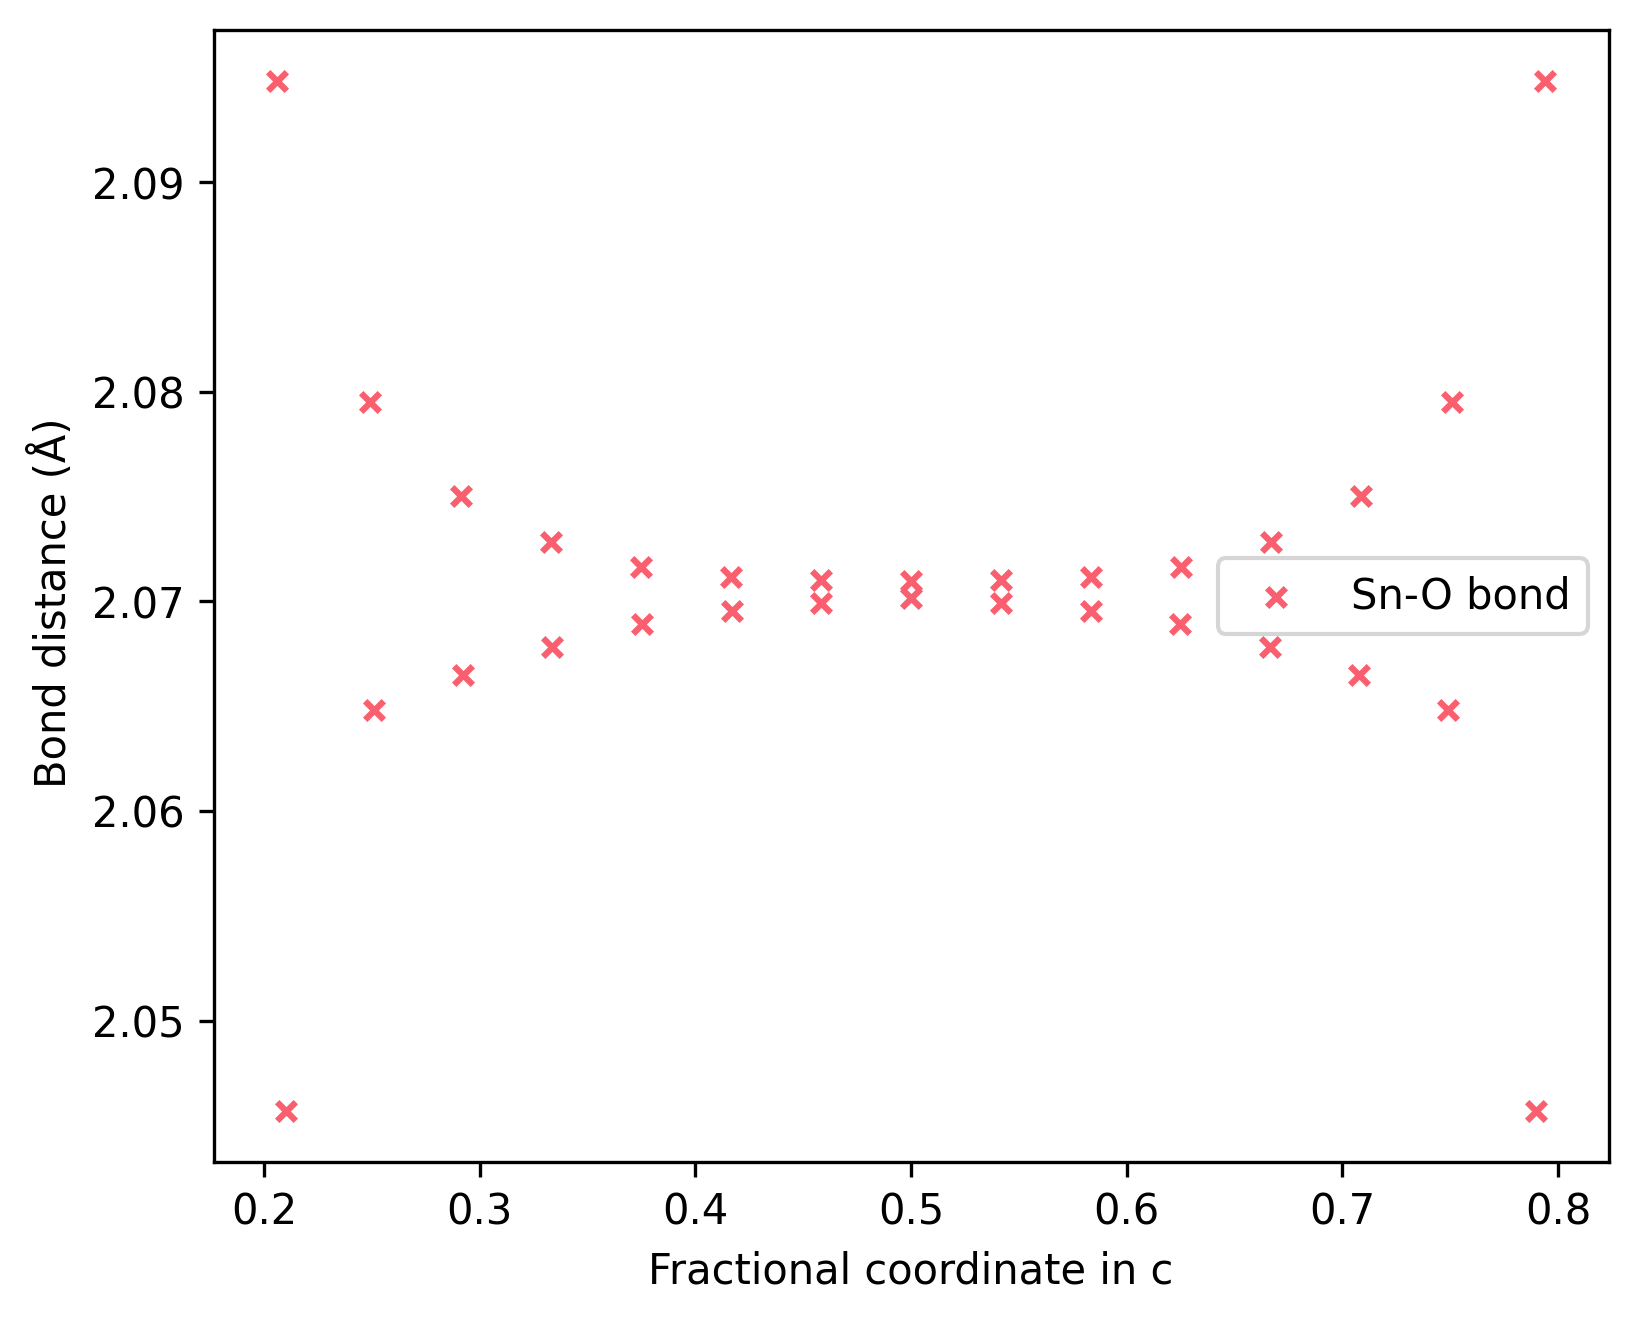

In [5]:
bond_analysis(structure=str(path_to_analysis_data.joinpath('CONTCAR_SnO2')), 
              bond=['Sn', 'O'], save_plt=True, markersize=20)

By default, the data is plotted using the default `save_plt=True`. Deviation is expected in bond length close to the surface - however the extrapolated line should be relatively flat in the bulk-like region. 

A .csv file of the data is also saved. We can suppress this and instead inspect the data in a pandas dataframe, e.g:

In [3]:
df = bond_analysis(structure=str(path_to_analysis_data.joinpath('CONTCAR_SnO2')), 
              bond=['Sn', 'O'], save_csv=False, save_plt=False)

df.head()

,Sn_index,Sn_c_coord,Sn-O_bond_distance
0,1,0.210039,2.045704
1,2,0.206004,2.094827
2,3,0.249207,2.079541
3,4,0.251195,2.064846
4,5,0.292350,2.066483


## Electrostatic potential

We can plot the planar average of the electrostatic potential using the aptly named `electrostatic_potential` function. It calculates both the planar and macroscopic potential automatically - the latter can be used to derive the ionisation potential and electron affintity directly. 

The planar potential is the average along one axis, calculated with pymatgen. The default axis specified here is c (but can be a or b as well) because we are interested in the potential in the vacuum region. 

The macroscopic potential is a rolling average of the planar potential with the periodicity of the unit cell as the window of the rolling average. The window is calculated as the ratio of the periodicity of the bulk system (`lattice_vector`) and the resolution of the raw potential data in that direction. In the latest version, `lattice_vector` is calculated automatically by default but it can be still manually specified. If unit cell the slab was cleaved contains more than one primitive unit cell, that number must be specified with `prim_to_conv`. In this example, the conventional unit cell comprises two primitive unit cells. 



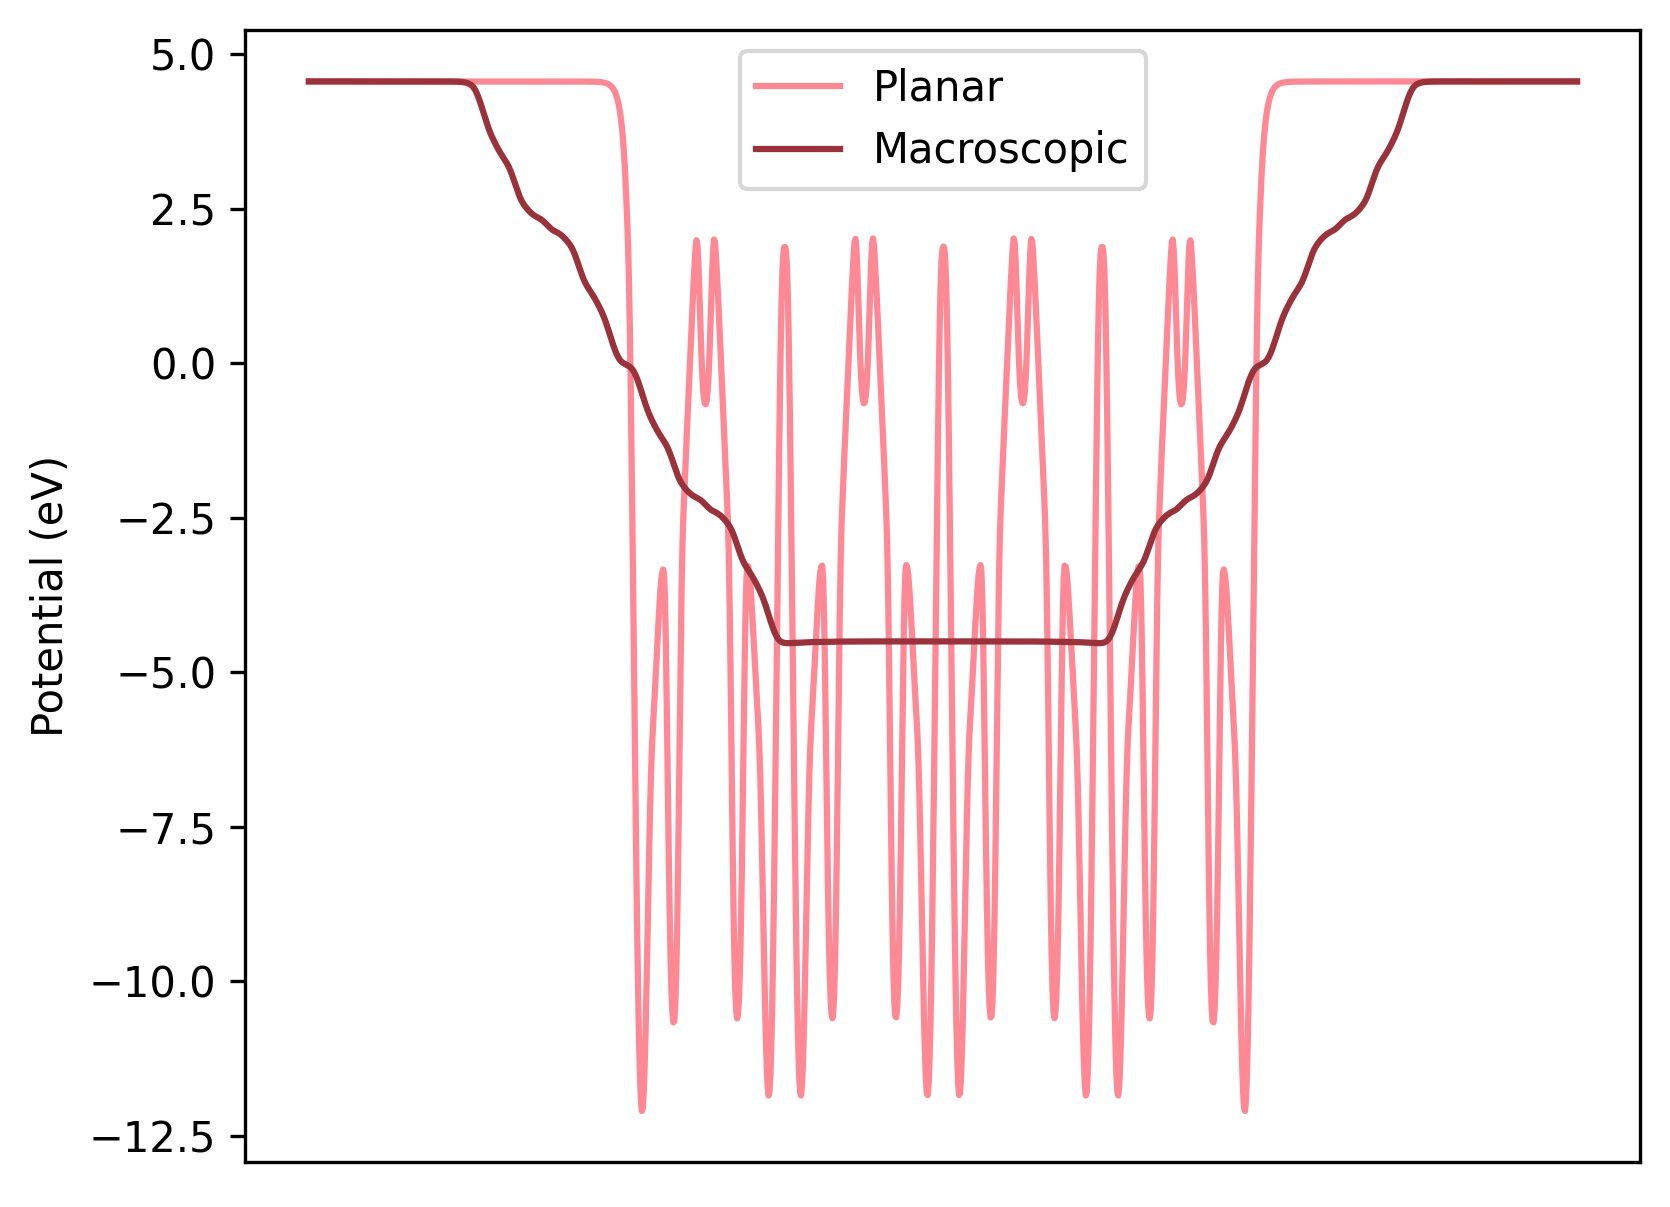

In [7]:
electrostatic_potential(locpot=path_to_analysis_data.joinpath('LOCPOT'), 
                        prim_to_conv=2, 
                        save_plt=True, 
                        save_csv=True)


### Band alignment

To calculate the band alignment using the macroscopic potential as shown in Keith Butler's [Macrodensity Tutorial](https://github.com/WMD-group/MacroDensity/tree/master/tutorials/Slab/SlabCalculation.ipynb) a convenient `surface_dipole` function can be used: 

In [16]:
sd = surface_dipole('potential.csv')
print(f'The surface dipole D_s is {sd} eV')

The surface dipole D_s is 9.06 eV


The dipole is calculated from the difference of the most positive data point (the vacuum macroscopic potential) and the mid-point of the slab (the slab potential). Because of this definition, this means **the function will only return meaningful answers for centred slabs**

From there if we know the bulk valence band maximum position $E_\textrm{VBM}$, the ionisation potential (IP) can be calculated from:

$\textrm{IP}$ = $D_s - E_\textrm{VBM}$

Electron affinity (EA) can then be calculated from the IP and the bulk band gap ($E_g$): 

$\textrm{EA} = \textrm{IP} - E_g$ 

In [25]:
ip = sd - 3.84
print(f'The ionisation potential is {ip :.2f} eV')

ea = ip - 1.2 
print(f'The electron affinity is {ea :.2f} eV')

The ionisation potential is 5.22 eV
The electron affinity is 4.02 eV


IP and EA can be visualised using [bapt](https://github.com/utf/bapt)

## Coordination environment
The analysis of coordination environment is an important for various reasons in both bulk and surface calculations. 

This [paper](https://chemrxiv.org/articles/Benchmarking_Coordination_Number_Prediction_Algorithms_on_Inorganic_Crystal_Structures/12508229?file=23211761) explains how the coordination number algorithms work and why `CrystalNN` is a good start for most purposes. It is recommended the validity of the algorithms is checked with bulk structure before using it in slabs, in particular in the case of metal-sulphur bonding in solid state. Most algorithms struggle with bonding environments near the surface in quaternary and quinary systems.  

In `Surfaxe` the coordination environment functions are `simple_nn` and `complex_nn`. 

- `simple_nn`: Uses `CrystalNN` by default but it can be used with any local environment algorithm. It is fast and intended for simple binaries and ternaries and bulk structures. 

- `complex_nn`: Uses the `CutOffDictNN` algorithm where the maximum bond distance needs to be specified in form of a dictionary of bond lengths. It is a slightly slower approach more suited for systems with complex bonding structure, or where other algorithms fail. Note that the bond lengths also need to be assigned oxidation states. 

In [4]:
# Simple example on the binary SnO2
df = simple_nn(start=str(path_to_analysis_data.joinpath('CONTCAR_SnO2')), 
          save_csv=False)

df.head()

,site_index,site,cn_start,nn_start
0,1,"(Sn, 1)",5,O O O O O
1,2,"(Sn, 2)",6,O O O O O O
2,3,"(Sn, 3)",6,O O O O O O
3,4,"(Sn, 4)",6,O O O O O O
4,5,"(Sn, 5)",6,O O O O O O


In this `complex_nn` example, we save the data as a csv. 

In [5]:
# Complex example on a quinary system
complex_nn(start=str(path_to_analysis_data.joinpath('POSCAR_LTA_010')), 
           cut_off_dict={('Ag+','S2-'): 3.09,
                          ('La3+','O2-'): 2.91,
                          ('La3+','S2-'): 3.559,
                          ('Ti4+','O2-'): 2.35,
                          ('Ti4+','S2-'): 2.91,}, 
           csv_fname='LTA_nn.csv')

## Miscellaneous 
Find the displacements of each atom after relaxation. The function only prints out the displacement greater than the maximum distance specified. As always, the data can be saved, this time in a txt file. 

In [6]:
df = cart_displacements(start=str(path_to_analysis_data.joinpath('POSCAR_LTA_010')), 
                   end=str(path_to_analysis_data.joinpath('CONTCAR_LTA_010')), 
                   save_txt=False)
df.head()

,site,atom,displacement
0,1,"(La, 1)",0.329
1,2,"(La, 2)",0.450
2,3,"(La, 3)",0.450
3,4,"(La, 4)",0.329
4,5,"(La, 5)",0.195
